In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
def composite_rsi_rsv_factor(df, rsi_window=14, n=10):
    """
    复合因子：结合RSV价格位置和RSI背离增强的上影线信号
    公式：复合因子 = RSV * KUP1_RSI
    
    其中：
    - RSV = (close - Min(low, n)) / (Max(high, n) - Min(low, n) + 1e-12)
    - KUP1_RSI = (high - max(open, close)) / open * rsi_divergence
    
    逻辑：
    1. 当价格处于近期低位(RSV值低)且出现超买区上影线时(KUP1_RSI值高)，预示强烈反转信号
    2. 当价格处于近期高位(RSV值高)且出现超买区上影线时(KUP1_RSI值高)，预示顶部反转信号
    3. 乘法组合放大两者同时出现的信号强度
    
    参数:
    df: 包含OHLCV数据的DataFrame
    rsi_window: RSI计算窗口 (默认14)
    n: RSV计算窗口 (默认10)
    """
    # 计算RSV因子
    high_max = df['high'].rolling(n).max()
    low_min = df['low'].rolling(n).min()
    price_range = high_max - low_min + 1e-12
    rsv = (df['close'] - low_min) / price_range
    
    # 计算RSI背离增强的上影线因子
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    overbought = np.where(df['rsi'] > 70, 1.5, 0.5)
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    kup1_rsi = upper_shadow / df['open'] * overbought
    
    # 复合因子：RSV * KUP1_RSI
    composite_factor = rsv * kup1_rsi
    
    return composite_factor

# 因子测试

In [7]:
evaluator.set_factor(
    factor_data_or_func=composite_rsi_rsv_factor,
    factor_name='composite_rsi_rsv_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.008457
   Rank_IC (Spearman): -0.000638
📊 信息比率:
   IR: 0.398410
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130731
   因子列: composite_rsi_rsv_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


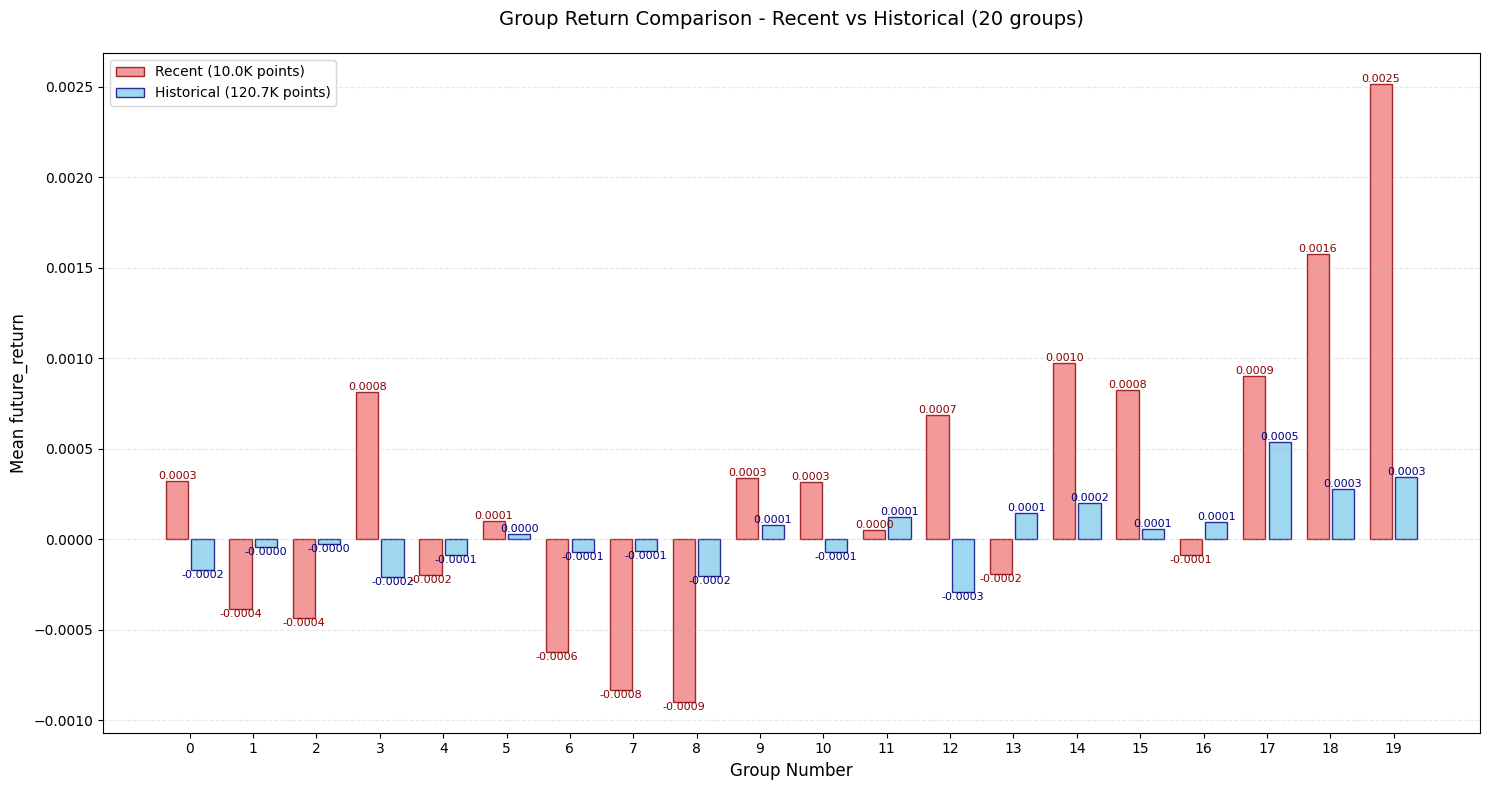

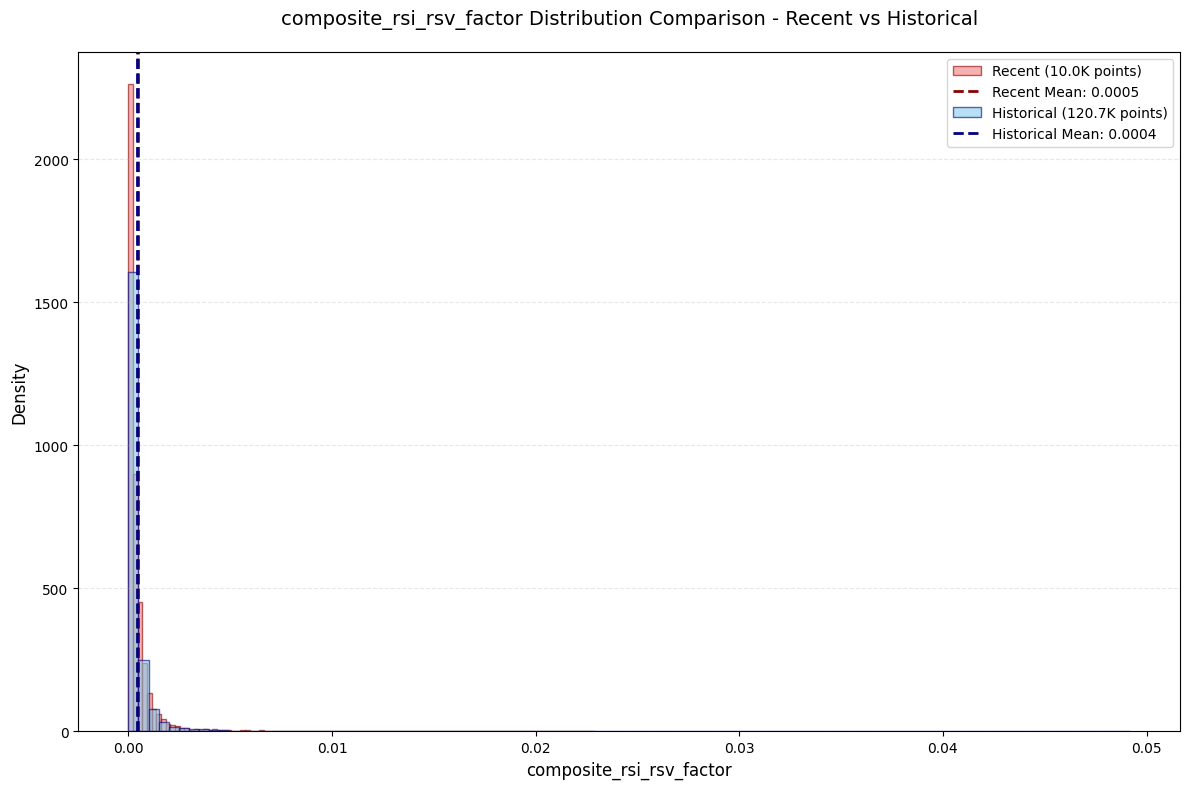

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [8]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)